In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import mlflow
import wandb
import seaborn as sns
from IPython.display import display, clear_output
import PIL.Image
import time
import imageio
import os
%matplotlib inline

from nets.PPOAgent import PPOAgent
from utils.Memory import ReplayBuffer

In [2]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

wandb.init(project="PPO-MountainCarContinuous", config={
    "episodes": 1000,
    "batch_size": 128,
    "buffer_size": int(1e5),
    "gamma": 0.99,
    "tau": 0.95,
    "actor_lr": 1e-4,
    "critic_lr": 1e-3,
    "weight_decay": 0,
    "clip_epsilon": 0.2,
    "update_steps": 4,
    "hidden_size": 256,  # Add hidden_size parameter
    "state_size": state_size,
    "action_size": action_size,
    "random_seed": 42
})

# Start an MLflow run
mlflow.start_run()
mlflow.log_params(wandb.config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amoz (arashmozhdehi). Use `wandb login --relogin` to force relogin


In [3]:
config = wandb.config

# Initialize the PPO agent
agent = PPOAgent(state_size, action_size, seed=config.random_seed, hidden_size=config.hidden_size,
                    lr=config.actor_lr, gamma=config.gamma, tau=config.tau,
                    clip_epsilon=config.clip_epsilon, update_steps=config.update_steps)
memory = ReplayBuffer()

In [4]:
os.makedirs('videos', exist_ok=True)
os.makedirs('check_points', exist_ok=True)

In [5]:
def display_frames_as_gif(frames, path):
    with imageio.get_writer(path, mode='I', fps=30) as writer:
        for frame in frames:
            display(PIL.Image.fromarray(frame))
            clear_output(wait=True)
            writer.append_data(frame)

In [6]:
def load_checkpoint(agent, path):
    if os.path.exists(path):
        agent.load_checkpoint(path)
        print("Loaded checkpoint from:", path)
    else:
        print("No checkpoint found at:", path)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

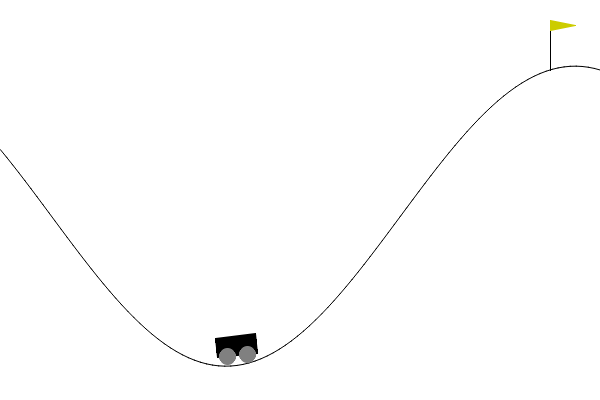

In [8]:
def ppo(n_episodes=1000, max_t=200, print_every=100, save_every=500, start_from_checkpoint=False):
    scores_deque = deque(maxlen=print_every)
    scores = []
    last_checkpoint_episode = 0
    if start_from_checkpoint:
        checkpoint_files = [f for f in os.listdir('check_points') if f.endswith('.pth')]
        if checkpoint_files:
            last_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
            last_checkpoint_episode = int(last_checkpoint.split('_')[1].split('.')[0])
            agent.load_checkpoint(os.path.join('check_points', last_checkpoint))

    for i_episode in range(last_checkpoint_episode + 1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        frames = []
        for t in range(max_t):
            state = np.array(state, dtype=np.float32)
            action, action_log_prob = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            value = agent.critic(torch.FloatTensor(state).to(device).unsqueeze(0)).item()
            memory.store(state, action, action_log_prob, reward, value, terminated or truncated)
            state = next_state
            score += reward

            # Capture the frame
            frame = env.render()  # Ensure to get RGB frames
            frames.append(frame)
            
            if terminated or truncated:
                break

        # Calculate next value and update agent
        next_value = agent.critic(torch.FloatTensor(next_state).to(device).unsqueeze(0)).item()
        rewards = memory.rewards
        values = memory.values + [next_value]  # Append the next value at the end
        dones = memory.dones
        advantages = agent.compute_gae(rewards, values, dones)
        returns = advantages + values[:len(advantages)]
        agent.update(memory.states, memory.actions, memory.log_probs, returns, advantages)
        memory.clear()

        scores_deque.append(score)
        scores.append(score)
        wandb.log({"Average Score": np.mean(scores_deque)})
        mlflow.log_metric("Score", score, step=i_episode)

        # Save the videos for the episode
        videos_path = os.path.join('videos', f'videos_episode_{i_episode}.gif')
        display_frames_as_gif(frames, videos_path)

        # Save model checkpoint
        if i_episode % save_every == 0:
            checkpoint_path = os.path.join('check_points', f'checkpoint_{i_episode}.pth')
            agent.save_checkpoint(checkpoint_path)
        
    mlflow.end_run()
    return scores

# Now you can specify whether to start from a checkpoint
scores = ppo(start_from_checkpoint=True)

wandb.finish()